In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('hdb-price-with-features-2004to2013.csv').iloc[:, 1:]
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured
0,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,11 TO 15,125.0,Improved,1989,76.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
1,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 20,120.0,Improved,1989,76.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
2,2012-04-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 05,120.0,Improved,1989,76.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
3,2011-08-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,77.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
4,2011-04-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,77.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1


In [3]:
cpi = pd.read_csv('monthly cpi.csv')
cpi = cpi.set_index('Data Series')
cpi_data = pd.DataFrame(cpi.columns, columns=['month'])
cpi_data['CPI'] = pd.to_numeric(np.array(cpi.loc['All Items']))
cpi_data = cpi_data.iloc[1: , :]
cpi_data['month'] = pd.to_datetime(cpi_data['month'])

cpi_data.head()

,month,CPI
1,2023-01-01,111.397
2,2022-12-01,111.186
3,2022-11-01,110.959
4,2022-10-01,109.893
5,2022-09-01,110.339


In [4]:
cpi_data.dtypes

month    datetime64[ns]
CPI             float64
dtype: object

In [5]:
df['month'] = pd.to_datetime(df['month'])
df = pd.merge(df, cpi_data, how = 'left')
df['adjusted_price'] = (df['resale_price'] / df['CPI']) * 100
df['year'] = pd.DatetimeIndex(df['month']).year
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,CPI,adjusted_price,year
0,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,11 TO 15,125.0,Improved,1989,76.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,95.917,677669.234859,2012
1,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 20,120.0,Improved,1989,76.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,95.917,677669.234859,2012
2,2012-04-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 05,120.0,Improved,1989,76.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,95.718,595499.279132,2012
3,2011-08-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,77.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,93.115,687322.128551,2011
4,2011-04-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,77.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,90.774,666490.404741,2011


In [6]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'address', 'latitude', 'longitude',
       'shortest_dist_mrt_name', 'shortest_dist_mrt', 'mrt_count_within_1km',
       'mrt_list_within_1km', 'shortest_dist_mall_name', 'shortest_dist_mall',
       'mall_count_within_1km', 'mall_list_within_1km', 'school_shortest_dist',
       'school_shortest_dist_name', 'good_sch_count_within_1km',
       'good_sch_list_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'CPI', 'adjusted_price', 'year'],
      dtype='object')

In [7]:
data = df.drop(['month','block', 'street_name', 'lease_commence_date',
                'resale_price','address', 'latitude', 'longitude',
                'shortest_dist_mrt_name', 'mrt_list_within_1km',
                'shortest_dist_mall_name','mall_list_within_1km',
                'school_shortest_dist_name', 'good_sch_list_within_1km', 'CPI'],
               axis = 1)
data.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
0,BISHAN,5 ROOM,11 TO 15,125.0,Improved,76.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,677669.234859,2012
1,BISHAN,5 ROOM,16 TO 20,120.0,Improved,76.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,677669.234859,2012
2,BISHAN,5 ROOM,01 TO 05,120.0,Improved,76.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,595499.279132,2012
3,BISHAN,5 ROOM,16 TO 18,125.0,Improved,77.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,687322.128551,2011
4,BISHAN,5 ROOM,19 TO 21,120.0,Improved,77.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,666490.404741,2011


In [8]:
# label encoding for Storey Range
le = LabelEncoder()
data = data.sort_values(by='storey_range')
data['storey_range'] = le.fit_transform(data['storey_range'])


# remove flat_types with less than 1000 instances
flat_types_counts = data['flat_type'].value_counts()
data = data[~data['flat_type'].isin(flat_types_counts[flat_types_counts < 1000].index)]

# label encoding for Storey Range and Flat Type
data = data.sort_values(by='flat_type')
data['flat_type'] = le.fit_transform(data['flat_type'])

In [9]:
data['flat_model'].value_counts()

Improved               72385
Model A                72023
New Generation         47905
Premium Apartment      19123
Simplified             14914
Standard               12069
Apartment              11028
Maisonette              7215
Model A2                5350
Adjoined flat            560
Model A-Maisonette       478
Terrace                  235
Improved-Maisonette       36
Premium Maisonette        33
2-room                    11
Name: flat_model, dtype: int64

In [10]:
# Re-categorize flat models into broader categories
replace_values = {'Model A-Maisonette':'Maisonette', 'Improved-Maisonette':'Maisonette',
                 'Premium Maisonette':'Maisonette', 'flat_model_Model A2':'flat_model_Model A'}
data = data.replace({'flat_model': replace_values})

# remove flat models with less than 1000 instances
flat_model_counts = data['flat_model'].value_counts()
data = data[~data['flat_model'].isin(flat_model_counts[flat_model_counts < 1000].index)]

In [11]:
data = pd.get_dummies(data, columns = ['town','flat_model'],drop_first = True)
data.sort_index(inplace = True)

#### Check for Multicolinearity and VIF

C:\Users\tammy\AppData\Local\Temp\ipykernel_26064\2484217916.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


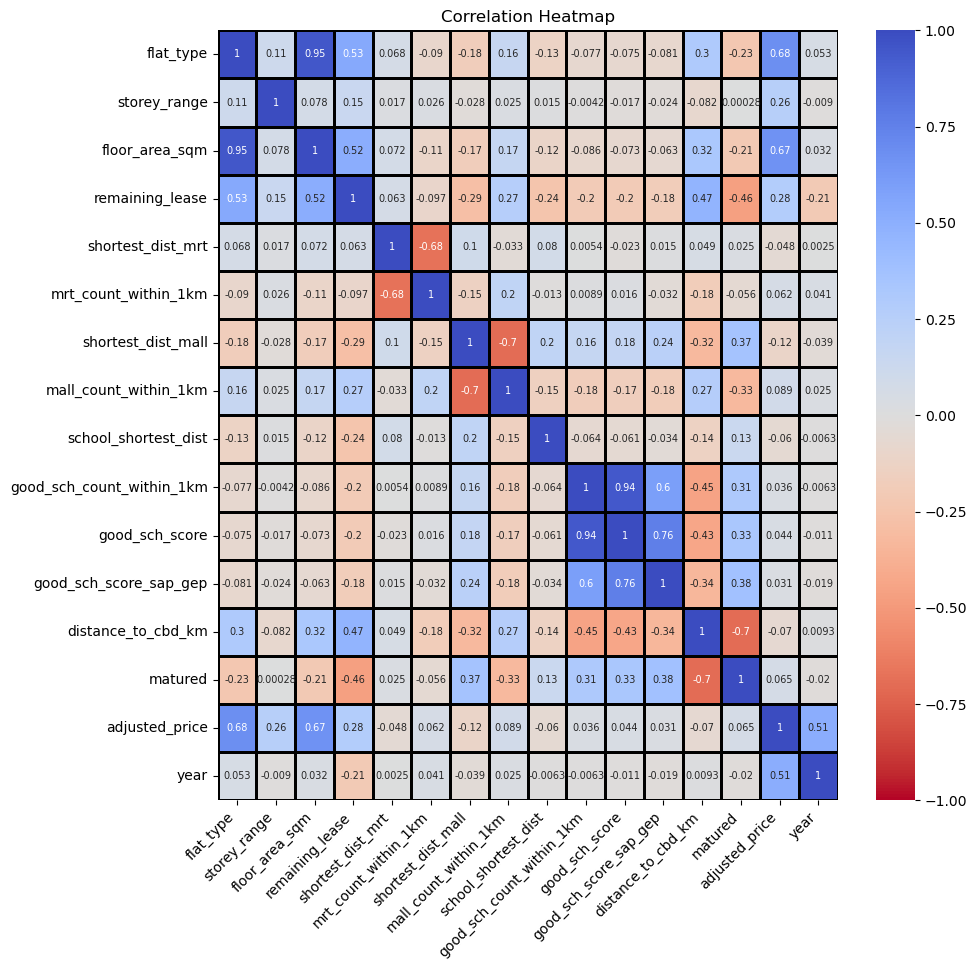

In [12]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(data.select_dtypes(include=['int32','int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()


In [13]:
# Multicollinearity
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(data.drop('adjusted_price',axis=1).select_dtypes(include=['int32','int64','float64']))

,variables,VIF,tolerance,meanVIF
0,flat_type,67.695453,0.014772,44.611966
1,storey_range,2.822651,0.354277,44.611966
2,floor_area_sqm,179.840993,0.005560,44.611966
3,remaining_lease,122.454399,0.008166,44.611966
4,shortest_dist_mrt,7.429593,0.134597,44.611966
5,mrt_count_within_1km,5.149646,0.194188,44.611966
6,shortest_dist_mall,8.010624,0.124834,44.611966
7,mall_count_within_1km,4.332943,0.230790,44.611966
8,school_shortest_dist,4.172645,0.239656,44.611966
9,good_sch_count_within_1km,17.763990,0.056294,44.611966


In [14]:
calc_vif(data.drop(['adjusted_price','mrt_count_within_1km','mall_count_within_1km','matured','good_sch_count_within_1km','flat_type','year'],axis=1).select_dtypes(include=['int32','int64','float64']))

,variables,VIF,tolerance,meanVIF
0,storey_range,2.792687,0.358078,10.87964
1,floor_area_sqm,21.938029,0.045583,10.87964
2,remaining_lease,41.722512,0.023968,10.87964
3,shortest_dist_mrt,3.759112,0.266020,10.87964
4,shortest_dist_mall,4.033345,0.247933,10.87964
5,school_shortest_dist,3.653709,0.273694,10.87964
6,good_sch_score,3.509907,0.284908,10.87964
7,good_sch_score_sap_gep,2.940819,0.340041,10.87964
8,distance_to_cbd_km,13.566638,0.073710,10.87964


#### Performance Measure

In [15]:
def model_performance(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print('R^2 score =', r2)
    print('Test loss (MAE):', mae)
    
    
    return(r2, mae)
    

#### Model Building

#### Linear Regression

### scaled np.log(y)

In [16]:
models_df = data.drop(['mrt_count_within_1km','mall_count_within_1km','matured',
                       'good_sch_score','flat_type','year'], axis=1)

In [17]:
X = models_df.drop(['adjusted_price'], axis = 1)
y = np.log(models_df['adjusted_price'])

In [18]:
# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [19]:
continuous_columns = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']


train_scale_data = X_train[continuous_columns]
train_no_scale_data = X_train.drop(continuous_columns, axis = 1)

scaler = StandardScaler()
scaler.fit(train_scale_data)

scaled_train = scaler.transform(train_scale_data)
scaled_train = pd.DataFrame(scaled_train, index = train_scale_data.index ,columns= continuous_columns)
X_train = pd.concat([scaled_train,train_no_scale_data], axis=1)


test_scale_data = X_test[continuous_columns]
test_no_scale_data = X_test.drop(continuous_columns, axis = 1)

scaled_test = scaler.transform(test_scale_data)
scaled_test = pd.DataFrame(scaled_test, index = test_scale_data.index ,columns= continuous_columns)
X_test = pd.concat([scaled_test,test_no_scale_data], axis=1)

In [20]:
lr = LinearRegression()
lin_reg_r2, lin_reg_mae = model_performance(lr)

R^2 score = 0.6268046516425397
Test loss (MAE): 0.17059177549385207


In [21]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
lr_importance = lr_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
lr_importance

,Features,Coeff
0,town_MARINE PARADE,0.394350
1,town_BUKIT TIMAH,0.312764
2,floor_area_sqm,0.279355
3,town_BUKIT MERAH,0.196148
4,flat_model_Premium Apartment,0.184894
5,town_PUNGGOL,0.180347
6,flat_model_Model A2,0.164402
7,town_QUEENSTOWN,0.106085
8,town_CENTRAL AREA,0.105483
9,flat_model_Model A,0.094681


In [22]:
X_constant = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_constant).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     8504.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        01:47:56   Log-Likelihood:                 35960.
No. Observations:              210047   AIC:                        -7.183e+04
Df Residuals:                  210004   BIC:                        -7.139e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Random Forest

In [23]:
rf = RandomForestRegressor()
rf_r2, rf_mae = model_performance(rf)

R^2 score = 0.94871637992426
Test loss (MAE): 0.05437887456535525


In [24]:
rf_importance = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance = rf_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
rf_importance

,Features,Coeff
0,floor_area_sqm,0.555873
1,remaining_lease,0.140704
2,distance_to_cbd_km,0.117647
3,shortest_dist_mrt,0.040540
4,shortest_dist_mall,0.027992
5,school_shortest_dist,0.022012
6,storey_range,0.016413
7,flat_model_New Generation,0.010171
8,flat_model_Premium Apartment,0.007901
9,flat_model_Model A,0.005579


#### XGBoost

In [25]:
xgb = XGBRegressor()
xgb_r2, xgb_mae = model_performance(xgb)

R^2 score = 0.899672198312659
Test loss (MAE): 0.08127235375006049


In [26]:
xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance = xgb_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
xgb_importance

,Features,Coeff
0,floor_area_sqm,0.162030
1,town_MARINE PARADE,0.094950
2,flat_model_Standard,0.053477
3,flat_model_New Generation,0.047785
4,flat_model_Model A,0.042106
5,flat_model_Premium Apartment,0.033716
6,flat_model_Simplified,0.032465
7,distance_to_cbd_km,0.028334
8,town_TAMPINES,0.028199
9,town_BUKIT PANJANG,0.026902


#### Out-of-Bag

In [27]:
oob_model = RandomForestRegressor(oob_score=True)
oob_r2, oob_mae = model_performance(oob_model)

R^2 score = 0.9485818526596927
Test loss (MAE): 0.05442627480952546


In [28]:
oob_importance = pd.DataFrame(list(zip(X_train.columns, oob_model.feature_importances_)), columns =['Features', 'Coeff'])
oob_importance = oob_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
oob_importance

,Features,Coeff
0,floor_area_sqm,0.555937
1,remaining_lease,0.140646
2,distance_to_cbd_km,0.117460
3,shortest_dist_mrt,0.040514
4,shortest_dist_mall,0.027985
5,school_shortest_dist,0.022044
6,storey_range,0.016426
7,flat_model_New Generation,0.010137
8,flat_model_Premium Apartment,0.007794
9,flat_model_Improved,0.005354


### y no scaled

In [29]:
X = models_df.drop(['adjusted_price'], axis = 1)
y = models_df['adjusted_price']

In [30]:
# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [31]:
continuous_columns = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']


train_scale_data = X_train[continuous_columns]
train_no_scale_data = X_train.drop(continuous_columns, axis = 1)

scaler = StandardScaler()
scaler.fit(train_scale_data)

scaled_train = scaler.transform(train_scale_data)
scaled_train = pd.DataFrame(scaled_train, index = train_scale_data.index ,columns= continuous_columns)
X_train = pd.concat([scaled_train,train_no_scale_data], axis=1)


test_scale_data = X_test[continuous_columns]
test_no_scale_data = X_test.drop(continuous_columns, axis = 1)

scaled_test = scaler.transform(test_scale_data)
scaled_test = pd.DataFrame(scaled_test, index = test_scale_data.index ,columns= continuous_columns)
X_test = pd.concat([scaled_test,test_no_scale_data], axis=1)

In [32]:
lr = LinearRegression()
lin_reg_r2, lin_reg_mae = model_performance(lr)

R^2 score = 0.6209013044431068
Test loss (MAE): 63808.5418693544


In [33]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
lr_importance = lr_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
lr_importance

,Features,Coeff
0,town_MARINE PARADE,150619.701207
1,town_BUKIT TIMAH,137261.824011
2,floor_area_sqm,99699.761540
3,town_BUKIT MERAH,76851.588002
4,town_PUNGGOL,60009.233384
5,town_QUEENSTOWN,44439.626157
6,town_BISHAN,38953.605967
7,flat_model_Premium Apartment,38078.228169
8,town_CLEMENTI,31279.296936
9,town_TOA PAYOH,31019.380679


In [34]:
X_constant = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_constant).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     8307.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        01:54:33   Log-Likelihood:            -2.6658e+06
No. Observations:              210047   AIC:                         5.332e+06
Df Residuals:                  210004   BIC:                         5.332e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Random Forest

In [35]:
rf = RandomForestRegressor()
rf_r2, rf_mae = model_performance(rf)

R^2 score = 0.9538920666902234
Test loss (MAE): 19719.233719411062


In [36]:
rf_importance = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance = rf_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
rf_importance

,Features,Coeff
0,floor_area_sqm,0.515537
1,distance_to_cbd_km,0.149155
2,remaining_lease,0.140265
3,shortest_dist_mrt,0.043821
4,shortest_dist_mall,0.029641
5,school_shortest_dist,0.020310
6,storey_range,0.019870
7,flat_model_Premium Apartment,0.009421
8,flat_model_New Generation,0.008191
9,flat_model_Model A,0.007069


#### XGBoost

In [37]:
xgb = XGBRegressor()
xgb_r2, xgb_mae = model_performance(xgb)

R^2 score = 0.9020822090196173
Test loss (MAE): 30082.20812174191


In [38]:
xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance = xgb_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
xgb_importance

,Features,Coeff
0,floor_area_sqm,0.162334
1,flat_model_New Generation,0.057881
2,town_MARINE PARADE,0.056436
3,flat_model_Premium Apartment,0.048611
4,distance_to_cbd_km,0.044664
5,flat_model_Model A,0.044106
6,flat_model_Simplified,0.036047
7,town_PASIR RIS,0.031915
8,town_PUNGGOL,0.029318
9,town_BUKIT PANJANG,0.024913


#### Out-of-Bag

In [39]:
oob_model = RandomForestRegressor(oob_score=True)
oob_r2, oob_mae = model_performance(oob_model)

R^2 score = 0.9538978302265687
Test loss (MAE): 19724.535743323526


In [40]:
oob_importance = pd.DataFrame(list(zip(X_train.columns, oob_model.feature_importances_)), columns =['Features', 'Coeff'])
oob_importance = oob_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop = True)
oob_importance

,Features,Coeff
0,floor_area_sqm,0.515641
1,distance_to_cbd_km,0.149649
2,remaining_lease,0.140096
3,shortest_dist_mrt,0.043881
4,shortest_dist_mall,0.029602
5,school_shortest_dist,0.020183
6,storey_range,0.019898
7,flat_model_Premium Apartment,0.009232
8,flat_model_New Generation,0.008301
9,flat_model_Model A,0.007240
